In [5]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
import time
import re
import itertools

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Natural Language processing
import nltk

## Stemming
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

# Learning Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer, confusion_matrix

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import Pipeline

# Plotting
from matplotlib.markers import MarkerStyle
from PIL import Image

# Corpus
from documentModel import DocumentModel as DM
from export_results import *
from utils import *

In [86]:
def total_cost_ratio(ground_truth = None, predictions = None, price = 1, expensive_class=1):
    
    n_class_to_remove = len(ground_truth[ground_truth==expensive_class])
    cm = confusion_matrix(ground_truth, predictions)
    
    if expensive_class == 1:
        n_fp = cm[0][1]
        n_fn = cm[1][0]
    elif expensive_class == 0:
        n_fp = cm[1][0]
        n_fn = cm[0][1]
    
    if n_fn != 0 or n_fp != 0:
        result = n_class_to_remove/(price * n_fn + n_fp) 
    else:
        result = 100.0

    return result


def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)
    Image.open(url + name + '.png').convert('L').save(url + name + '.png')
    
def plot_image(x, y, title="title", ylim = [0, 1.02], xlim = [2, 50.5], 
               colors="rgbmyc", models=None, name="name", labels=[], ylabel = "ylabel", 
               loc="better", markers=".,ov<>", pattern=""):
    plt.figure(figsize=(14,13))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Misclassification Cost Ratio")
    plt.ylabel(ylabel)
    plt.style.use('paper.mplstyle')
    
    filled_markers = ('<', 'D', 'o', '|', 'v', '>', 'p', 'd') #' '^', ', '>', '8', 's', 'p', '*', 'h', 'H', , 'd')
    fillstyles = ('full', 'full', 'full', 'full', 'top', 'none')

    i = 0
    for model in models:
        model_name = model[0]
        if re.match(pattern, model_name) is not None:
            plt.plot(x, y[model_name])
            marker = MarkerStyle(marker=filled_markers[i], fillstyle=fillstyles[i])
            plt.scatter(x, y[model_name], marker=marker, s=300, label=model[0])
            i+=1
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend(loc=loc, prop={'size':30})

    save_image(plt,'../images/', name)
    plt.show()
    
def filter_results(recalls, precisions, models=None, pattern=".*"):

    recalls_avg = {}
    precisions_avg = {}

    for model in models:
        name = model[0]
        if re.match(pattern, name) is not None:
            recalls_avg[name] = recalls[name]
            precisions_avg[name] = precisions[name]
    
    return recalls_avg, precisions_avg
    
def normalize(recall_avg, precision_avg):
    recall_avg_normalized = {}

    for key, value in recall_avg.items():
        recall_avg_normalized[key] = []

    for key, values in recall_avg.items():
        for value in values:
            recall_avg_normalized[key].append(float(value * 100))
 

    precision_avg_normalized = {}

    for key, value in precision_avg.items():
        precision_avg_normalized[key] = []

    for key, values in precision_avg.items():
        for value in values:
            precision_avg_normalized[key].append(float(value * 100)) 
            
    return recall_avg_normalized, precision_avg_normalized

def set_baseline(name):
    recall_baseline = recall_avg_normalized[name]
    precision_baseline = precision_avg_normalized[name]
    
    return recall_baseline, precision_baseline

#".*Stemming.*(Bayes|SVM)"    
def summary(recalls, precisions, pattern=".*"):
    r, p = filter_results(recalls, precisions, pipes, pattern) 
    max_recall = 0.0
    best_precision = 0.0
    best_cost = "1:1"
    best_algorithm = ''

    for (name, recalls), (name_2, precisions) in zip(r.items(), p.items()):
        print("Executing: " + name + " ...")
        recs = []
        pres = []
        recs.append(np.mean(recalls))
        pres.append(np.mean(precisions))
        for i, (recall, precision) in enumerate(zip(recalls, precisions)):
            if recall > max_recall:
                best_cost = labels[i]
                max_recall = recall
                best_precision = precisions[i]
                best_algorithm = name
            if recall == max_recall and precision > best_precision:
                best_cost = labels[i]
                max_recall = recall
                best_precision = precisions[i]
                best_algorithm = name
                
    return best_cost, max_recall, best_precision, best_algorithm, np.mean(recs), np.mean(pres) 

def write_results(n_experiment, nlp, algorithm, cost_ratio, precision, recall):
    import pymysql.cursors

    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')

    try:
        with connection.cursor() as cursor:
            sql = "INSERT INTO results(n_experiment, nlp, algorithm, cost_ratio, prec, recall) \
            VALUES(%s, %s, %s, %s, %s, %s)"
            cursor.execute(sql, (n_experiment, nlp, algorithm, cost_ratio, str(precision), str(recall)))
            connection.commit()
    
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
def reset_results():
    import pymysql.cursors

    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')

    try:
        with connection.cursor() as cursor:
            sql = "TRUNCATE TABLE results;"
            cursor.execute(sql)
            connection.commit()
    
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
def load_results():
    import pymysql.cursors

    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')
    results = []

    try:
        sql = "SELECT * FROM results"
        results = pd.read_sql(sql, connection)
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
    return results

In [7]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [8]:
def init():
    pipelines = []

    for element in itertools.product(estimators, nlp):
        name = element[1][0] + '-' + element[0][0]
        pipeline = Pipeline([('nlp', element[1][1]), ('clf', element[0][1])])
        pipelines.append((name , pipeline))
        
    return pipelines

# Business Rule Classification

In [9]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


## NLP Exploration

In [10]:
rule_data = pd.DataFrame({"rule": X, "tag": y})
permissions = rule_data[rule_data["tag"] == 0]
prohibitions = rule_data[rule_data["tag"] == 1]

In [11]:
permissions.head()

,rule,tag
0,Aplicar sobre el suelo en pequeños montones o ...,0
3,"Aplicar en pulverización normal, variando la d...",0
4,En la etiqueta deberán figurar las instruccion...,0
9,"Aplicar en pulverización normal, dependiendo d...",0
14,Aplicar en pulverización normal,0


In [12]:
prohibitions.head()

,rule,tag
1,Evitar que el producto caiga sobre las plantas...,1
2,Advertir en la etiqueta que es peligroso para ...,1
5,No mezclar con aceites ni productos de reacció...,1
6,No aplicar aceites minerales durante los 21 dí...,1
7,No aplicar en cultivos cuyos frutos sean desti...,1


## Experiment Variables

In [13]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", r"1:$10^2$", r"1:$10^3$", r"1:$10^6$"]
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets

costs = np.array([2, 3, 4, 6, 10, 25, 50, 100, 1000, 1000000])
axis_costs = np.arange(1,11,1)
cxlim = [0.8, 10.15]
estimators = [("Naive Bayes", MultinomialNB(fit_prior=False)), 
              ("Random Forest", RandomForestClassifier(n_estimators=20)), 
              ("SVM", SVC(kernel='linear', C = 0.1)),
              ("Baseline", DummyClassifier(strategy = "constant", constant=1))]

nlp = [("None", TfidfVectorizer(use_idf = True, stop_words=stop_words)),
       ("Stemming", TfidfVectorizer(use_idf = True, stop_words=stop_words, tokenizer=LemmaTokenizer())), 
       ("Bigrams", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(2, 2))), 
       ("Combination", TfidfVectorizer(use_idf = True, stop_words=stop_words, ngram_range=(1, 2)))]

## Main Experiment Loop

In [87]:
def experiment(pattern = ".*", n_times = 1):
    
    t0 = time.time()
    pipes = init()
    reset_results()
    
    for i in range(n_times):
        print("Experiment number %d" % (i+1))
        sss = StratifiedKFold(y, n_folds = 10, shuffle = True, random_state = random.randint(0,100))
        for estimator in pipes:
            name = estimator[0]
            extractor = estimator[1].steps[0][1].fit(X)
            if re.match(pattern, name) is not None:
                print("Trying: " + name + " ...")
                for cost in costs:
                    if "Naive Bayes" in name:
                        model = estimator[1].set_params(clf__class_prior=[1/cost, (cost-1)/cost]).steps[1][1]
                    elif "Random Forest" in name:
                        model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                    elif "SVM" in name:
                        model = estimator[1].set_params(clf__class_weight={1:cost-1}).steps[1][1]
                    elif "Baseline" in name:
                        model = estimator[1].steps[1][1]
            
                    precisions = []
                    recalls = []
                    for train_index, test_index in sss:
                        X_train, X_test = \
                            extractor.transform(X)[train_index], extractor.transform(X)[test_index]
                        y_train, y_test = y[train_index], y[test_index]
                        model.fit(X_train, y_train)
                        precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                        recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
                    
                    write_results(str(i), name.split("-")[0], name.split("-")[1], \
                                  str(cost), np.mean(np.array(precisions)), \
                                  np.mean(np.array(recalls)))
                
    t1 = time.time()
    print()
    print("Execution time: %.3f min" % ((t1 - t0)/60))

In [89]:
experiment(n_times = 10)

Experiment number 1
Trying: None-Naive Bayes ...
Trying: Stemming-Naive Bayes ...
Trying: Bigrams-Naive Bayes ...
Trying: Combination-Naive Bayes ...
Trying: None-Random Forest ...
Trying: Stemming-Random Forest ...
Trying: Bigrams-Random Forest ...
Trying: Combination-Random Forest ...
Trying: None-SVM ...
Trying: Stemming-SVM ...
Trying: Bigrams-SVM ...
Trying: Combination-SVM ...
Trying: None-Baseline ...
Trying: Stemming-Baseline ...
Trying: Bigrams-Baseline ...
Trying: Combination-Baseline ...
Experiment number 2
Trying: None-Naive Bayes ...
Trying: Stemming-Naive Bayes ...


KeyboardInterrupt: 

In [ ]:
data = load_results()

## Analysis

## All classifiers

In [ ]:
from scipy.stats import *

In [ ]:
#stats.sem(data[data["algorithm"] == "SVM"]["recall"])

In [36]:
bayes = data[data["algorithm"] == "Naive Bayes"]["recall"]
svm = data[data["algorithm"] == "SVM"]["recall"]

### Parametric

In [38]:
z_stat, p_val = ttest_ind(bayes, svm, equal_var=False)
if p_val < 0.05:
    print("Statistically significan different results")

Statistically significan different results


### Non-parametric

In [39]:
z_stat, p_val = wilcoxon(bayes, svm, zero_method='wilcox', correction=False)
if p_val < 0.05:
    print("Statistically significan different results")

Statistically significan different results


In [54]:
dp = data[data["recall"] == data["recall"].max()]
dp[dp["prec"] == dp["prec"].max()]

,id,nlp,algorithm,cost_ratio,prec,recall,tcr
404,405,None,Random Forest,2,1,1,0
414,415,None,Random Forest,3,1,1,0
424,425,None,Random Forest,4,1,1,0
504,505,Stemming,Random Forest,2,1,1,0
514,515,Stemming,Random Forest,3,1,1,0
524,525,Stemming,Random Forest,4,1,1,0
534,535,Stemming,Random Forest,6,1,1,0
544,545,Stemming,Random Forest,10,1,1,0
604,605,Bigrams,Random Forest,2,1,1,0
614,615,Bigrams,Random Forest,3,1,1,0


In [13]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*")

Executing: Combination-Naive Bayes ...
Executing: Bigrams-Naive Bayes ...
Executing: Stemming-Baseline ...
Executing: Bigrams-Baseline ...
Executing: Combination-Baseline ...
Executing: None-Baseline ...
Executing: None-Random Forest ...
Executing: None-SVM ...
Executing: None-Naive Bayes ...
Executing: Bigrams-SVM ...
Executing: Stemming-Naive Bayes ...
Executing: Bigrams-Random Forest ...
Executing: Combination-SVM ...
Executing: Combination-Random Forest ...
Executing: Stemming-SVM ...
Executing: Stemming-Random Forest ...


In [14]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
86.7777777778
84.3381594202


## Bayes

In [15]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Bayes")

Executing: Combination-Naive Bayes ...
Executing: Bigrams-Naive Bayes ...
Executing: None-Naive Bayes ...
Executing: Stemming-Naive Bayes ...


In [16]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
98.568627451
48.7874040065


## SVM

In [97]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*SVM")

Executing: None-SVM ...
Executing: Stemming-SVM ...
Executing: Bigrams-SVM ...
Executing: Combination-SVM ...


In [98]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:6
99.41176470588235
51.59298770001042
Bigrams-SVM
91.4738562092
64.3826920552


## Random Forest

In [99]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Random.*")

Executing: Bigrams-Random Forest ...
Executing: Stemming-Random Forest ...
Executing: None-Random Forest ...
Executing: Combination-Random Forest ...


In [100]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:$10^2$
93.75816993464052
73.4244596903399
Combination-Random Forest
88.0588235294
82.6995222678


## No preprocessing Step

In [101]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*None.*(Bayes|SVM|.*Forest)")

Executing: None-SVM ...
Executing: None-Random Forest ...
Executing: None-Naive Bayes ...


In [102]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:25
100.0
44.00633773308192
None-Naive Bayes
98.7973856209
48.9389819863


## Bigrams

In [103]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Bigra.*(Bayes|SVM|.*Forest)")

Executing: Bigrams-Random Forest ...
Executing: Bigrams-SVM ...
Executing: Bigrams-Naive Bayes ...


In [104]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:10
100.0
44.718557180116036
Bigrams-Naive Bayes
99.362745098
45.8460064913


## Combining bigrams and unigrams

In [105]:
best_cost, max_recall, best_precision, best_algorithm, mean_recall, mean_precision = \
    summary(recall_avg_normalized, precision_avg_normalized, pattern=".*Comb.*(Bayes|SVM|.*Forest)")

Executing: Combination-Random Forest ...
Executing: Combination-SVM ...
Executing: Combination-Naive Bayes ...


In [106]:
print(best_cost)
print(max_recall)
print(best_precision)
print(best_algorithm)
print(mean_recall)
print(mean_precision)

1:25
100.0
44.251912831181116
Combination-Naive Bayes
98.9673202614
48.9234072084


## Plot best results

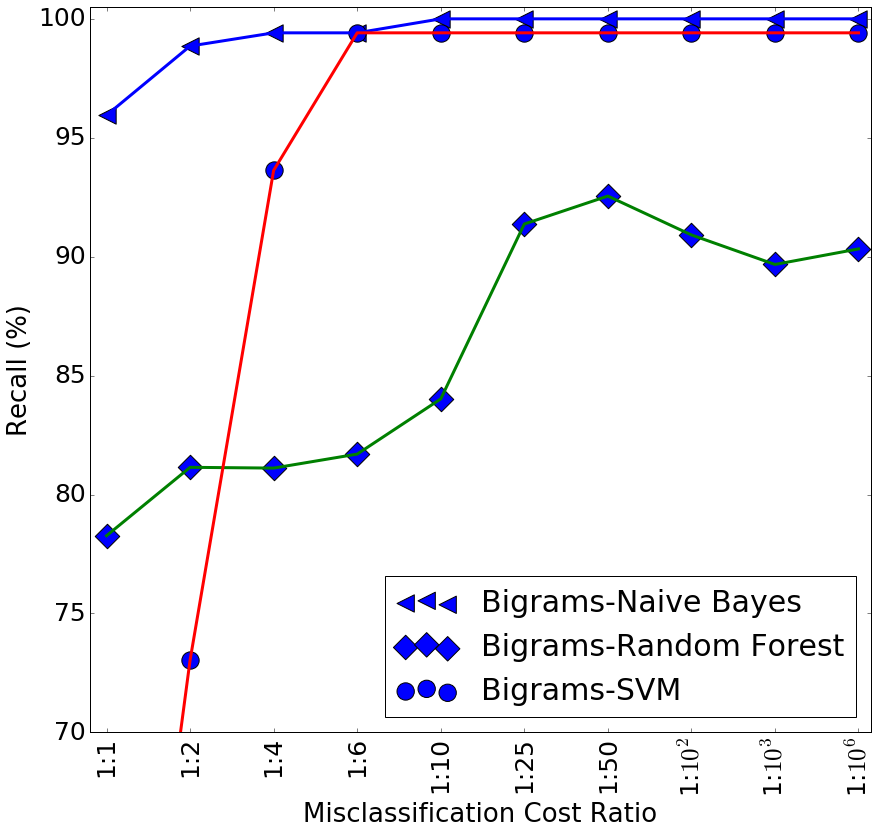

In [107]:
plot_image(axis_costs, recall_avg_normalized, title="RECALL", ylim = [70., 100.5], 
           xlim = cxlim, models=pipes, name="recall", labels=labels, ylabel="Recall (%)", 
           loc='lower righ', markers="<Do|", pattern="(.*Bigram.*(Bayes|SVM|.*Forest)|None_Baseline)")

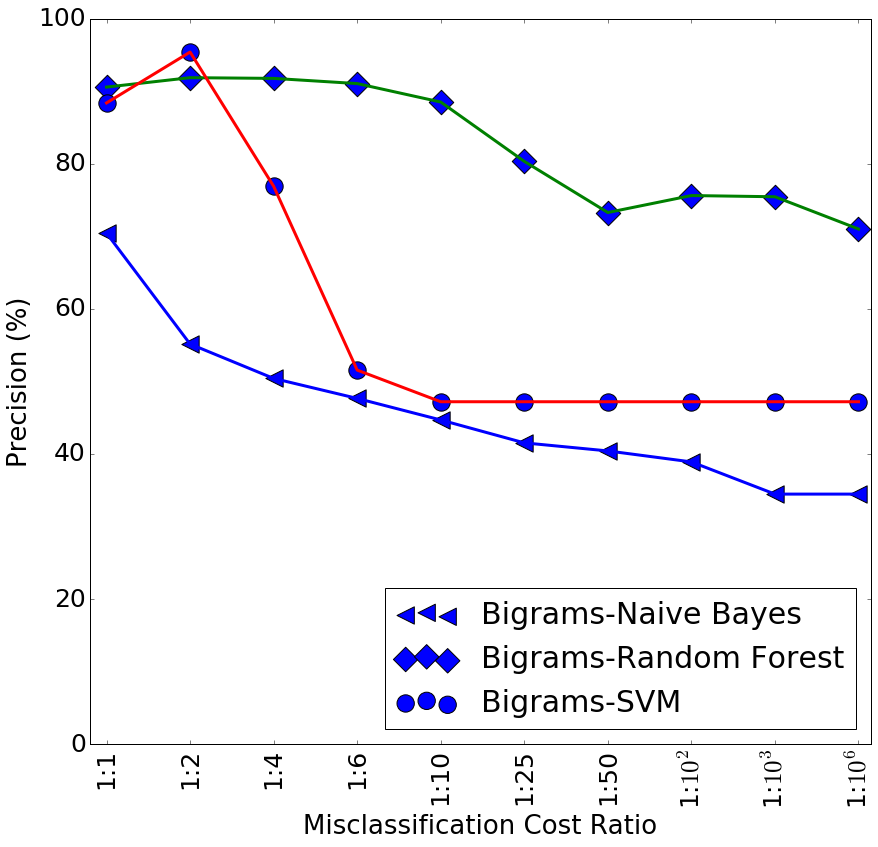

In [108]:
plot_image(axis_costs, precision_avg_normalized, title="PRECISION", ylim = [0., 100], 
           xlim = cxlim, colors="rgbmyc", models=pipes, name="precision", labels = labels, ylabel="Precision (%)",
           loc ="lower right", markers="<Do|", pattern="(.*Bigram.*(Bayes|SVM|.*Forest)|None_Baseline)")